# Libraries

In [1]:
# Main
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Sklearn
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder, StandardScaler

# Keras
import tensorflow as tf
from tensorflow.keras import regularizers, Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Embedding, Input, concatenate
from tensorflow.keras.optimizers import Adam, Adamax, Nadam
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard, ModelCheckpoint
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor

# Other
import os

# Setup

In [2]:
pd.options.display.max_columns = None
pd.options.mode.chained_assignment = None

In [3]:
plt.style.use('fivethirtyeight')

In [4]:
path = "../CSV Files"

train = pd.read_csv(path+"/train.csv", index_col="id")
test = pd.read_csv(path+"/test.csv",  index_col="id")

# Functions

In [5]:
def wrangle(X):
    # make a copy
    X = X.copy()
    
    # encode "t" and "f" as 1's and 0's
    X['host_has_profile_pic'][X['host_has_profile_pic']=='t'] = 1
    X['host_has_profile_pic'][X['host_has_profile_pic']=='f'] = 0
    
    X['host_identity_verified'][X['host_identity_verified']=='t'] = 1
    X['host_identity_verified'][X['host_identity_verified']=='f'] = 0
    
    X['host_has_profile_pic'] = X['host_has_profile_pic'].astype(float)
    X['host_identity_verified'] = X['host_identity_verified'].astype(float)
    
    X['instant_bookable'][X['instant_bookable']=='t'] = 1
    X['instant_bookable'][X['instant_bookable']=='f'] = 0
    
    # Group some of the many property types together
    X['property_type'][X['property_type'].isin(['Boat','Tent','Castle','Yurt', 'Hut', 'Treehouse',
                                                'Chalet','Earth House','Tipi','Cave',
                                                'Train','Parking Space','Island','Casa particular',
                                                'Lighthouse', 'Vacation home', 'Serviced apartment'])] = 'Other'

    # columns with unusable variance
    unusable_variance = ['zipcode']

    # columns with high percentage of missing values
    high_nans = ['first_review','host_response_rate','last_review',
                 'review_scores_rating','thumbnail_url']

    # categorical variables with high cardinality
    # 'neighborhood' has 620 and 'thumbnail_url' has many thousands
    high_card = ['neighbourhood','thumbnail_url','name','amenities',
                 'description', 'host_since']

    # Get the price and drop the log of price
    X['price'] = np.exp(X['log_price'])
    X = X.drop(['log_price'] + unusable_variance + high_nans + high_card, axis=1)

    return X

In [6]:
def prepare_inputs(X_train, X_test):
    X_train_enc, X_test_enc = list(), list()
    # label encode each column
    for i in range(X_train.shape[1]):
        le = LabelEncoder()
        # encode
        train_enc = le.fit_transform(X_train.iloc[:, i].values)
        test_enc = le.fit_transform(X_test.iloc[:, i].values)
        # store
        X_train_enc.append(train_enc)
        X_test_enc.append(test_enc)
    return X_train_enc, X_test_enc

In [7]:
def scale_inputs(X_train, X_test):
    ss = StandardScaler()
    ss.fit_transform(X_train, X_test)
    return X_train, X_test

In [ ]:
def model_creation_emb():
    lr = .001
    opt = Adam(lr)
#     input_shape = 16
#     prob = .50
    l2 = 0.02

    il_nodes = 10
#     hl_nodes_1 = 64*8
#     hl_nodes_2 = 64*8
#     hl_nodes_3 = 64*8
#     hl_nodes_4 = 64*8
    ol_nodes = 1
    
    dense = Dense(il_nodes,
                  activation='relu', 
                  kernel_regularizer=regularizers.l2(l2))(emb)
    
    output = Dense(ol_nodes,
                   activation='linear')(dense)
    
    model = Model(inputs=in_layers,
                  outputs=output)
    
    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])
    
    return model

In [8]:
def model_creation():
    lr = .001
    opt = Adam(lr)
    input_shape = 16
    prob = .50
    l2 = 0.02

    il_nodes = 64*8
    hl_nodes_1 = 64*8
    hl_nodes_2 = 64*8
    hl_nodes_3 = 64*8
    hl_nodes_4 = 64*8
    ol_nodes = 1
    
    model = Sequential([
    Dense(il_nodes, 
          activation='relu', 
          input_dim=input_shape,
          kernel_regularizer=regularizers.l2(l2)),
    
    Dropout(prob),
        
    Dense(hl_nodes_1, 
          activation='relu',
          kernel_regularizer=regularizers.l2(l2)),
        
    Dropout(prob),
        
    Dense(hl_nodes_2, 
          activation='relu',
          kernel_regularizer=regularizers.l2(l2)),
        
    Dropout(prob),
    
    Dense(hl_nodes_3, 
          activation='relu',
          kernel_regularizer=regularizers.l2(l2)),
        
    Dropout(prob),
        
    Dense(hl_nodes_4, 
          activation='relu',
          kernel_regularizer=regularizers.l2(l2)),
        
    Dropout(prob),
        
    Dense(ol_nodes, 
          activation='linear')
])
    
    model.compile(optimizer=opt,
                  loss='mean_squared_error',
                  metrics=['mean_absolute_error'])

    return model

# EDA

In [9]:
print(train.shape)
train.head()

(74111, 28)


,log_price,property_type,room_type,amenities,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,description,first_review,host_has_profile_pic,host_identity_verified,host_response_rate,host_since,instant_bookable,last_review,latitude,longitude,name,neighbourhood,number_of_reviews,review_scores_rating,thumbnail_url,zipcode,bedrooms,beds
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,
6901257,5.010635,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",3,1.0,Real Bed,strict,True,NYC,"Beautiful, sunlit brownstone 1-bedroom in the ...",2016-06-18,t,t,NaN,2012-03-26,f,2016-07-18,40.696524,-73.991617,Beautiful brownstone 1-bedroom,Brooklyn Heights,2,100.0,https://a0.muscache.com/im/pictures/6d7cbbf7-c...,11201,1.0,1.0
6304928,5.129899,Apartment,Entire home/apt,"{""Wireless Internet"",""Air conditioning"",Kitche...",7,1.0,Real Bed,strict,True,NYC,Enjoy travelling during your stay in Manhattan...,2017-08-05,t,f,100%,2017-06-19,t,2017-09-23,40.766115,-73.989040,Superb 3BR Apt Located Near Times Square,Hell's Kitchen,6,93.0,https://a0.muscache.com/im/pictures/348a55fe-4...,10019,3.0,3.0
7919400,4.976734,Apartment,Entire home/apt,"{TV,""Cable TV"",""Wireless Internet"",""Air condit...",5,1.0,Real Bed,moderate,True,NYC,The Oasis comes complete with a full backyard ...,2017-04-30,t,t,100%,2016-10-25,t,2017-09-14,40.808110,-73.943756,The Garden Oasis,Harlem,10,92.0,https://a0.muscache.com/im/pictures/6fae5362-9...,10027,1.0,3.0
13418779,6.620073,House,Entire home/apt,"{TV,""Cable TV"",Internet,""Wireless Internet"",Ki...",4,1.0,Real Bed,flexible,True,SF,This light-filled home-away-from-home is super...,NaN,t,t,NaN,2015-04-19,f,NaN,37.772004,-122.431619,Beautiful Flat in the Heart of SF!,Lower Haight,0,NaN,https://a0.muscache.com/im/pictures/72208dad-9...,94117.0,2.0,2.0
3808709,4.744932,Apartment,Entire home/apt,"{TV,Internet,""Wireless Internet"",""Air conditio...",2,1.0,Real Bed,moderate,True,DC,"Cool, cozy, and comfortable studio located in ...",2015-05-12,t,t,100%,2015-03-01,t,2017-01-22,38.925627,-77.034596,Great studio in midtown DC,Columbia Heights,4,40.0,NaN,20009,0.0,1.0


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 6901257 to 3534845
Data columns (total 28 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   log_price               74111 non-null  float64
 1   property_type           74111 non-null  object 
 2   room_type               74111 non-null  object 
 3   amenities               74111 non-null  object 
 4   accommodates            74111 non-null  int64  
 5   bathrooms               73911 non-null  float64
 6   bed_type                74111 non-null  object 
 7   cancellation_policy     74111 non-null  object 
 8   cleaning_fee            74111 non-null  bool   
 9   city                    74111 non-null  object 
 10  description             74111 non-null  object 
 11  first_review            58247 non-null  object 
 12  host_has_profile_pic    73923 non-null  object 
 13  host_identity_verified  73923 non-null  object 
 14  host_response_rate      55812 

In [11]:
train = wrangle(train)

In [12]:
train.head()

,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,number_of_reviews,bedrooms,beds,price
id,,,,,,,,,,,,,,,,,
6901257,Apartment,Entire home/apt,3,1.0,Real Bed,strict,True,NYC,1.0,1.0,0,40.696524,-73.991617,2,1.0,1.0,150.0
6304928,Apartment,Entire home/apt,7,1.0,Real Bed,strict,True,NYC,1.0,0.0,1,40.766115,-73.989040,6,3.0,3.0,169.0
7919400,Apartment,Entire home/apt,5,1.0,Real Bed,moderate,True,NYC,1.0,1.0,1,40.808110,-73.943756,10,1.0,3.0,145.0
13418779,House,Entire home/apt,4,1.0,Real Bed,flexible,True,SF,1.0,1.0,0,37.772004,-122.431619,0,2.0,2.0,750.0
3808709,Apartment,Entire home/apt,2,1.0,Real Bed,moderate,True,DC,1.0,1.0,1,38.925627,-77.034596,4,0.0,1.0,115.0


In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74111 entries, 6901257 to 3534845
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   property_type           74111 non-null  object 
 1   room_type               74111 non-null  object 
 2   accommodates            74111 non-null  int64  
 3   bathrooms               73911 non-null  float64
 4   bed_type                74111 non-null  object 
 5   cancellation_policy     74111 non-null  object 
 6   cleaning_fee            74111 non-null  bool   
 7   city                    74111 non-null  object 
 8   host_has_profile_pic    73923 non-null  float64
 9   host_identity_verified  73923 non-null  float64
 10  instant_bookable        74111 non-null  object 
 11  latitude                74111 non-null  float64
 12  longitude               74111 non-null  float64
 13  number_of_reviews       74111 non-null  int64  
 14  bedrooms                74020 

# Split

In [14]:
target = 'price'
X = train.drop(target, axis=1)
y = train[target]

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=.20,
                                                    random_state=0)

In [16]:
print(X_train.shape)
print(X_test.shape)

(59288, 16)
(14823, 16)


# Baseline

In [17]:
baseline = mean_absolute_error(y_train, [y_train.mean()] * len(y_train))
print('Baseline MAE:', round(baseline,2))

Baseline MAE: 97.59


# Pre-fitting

In [23]:
X_train, X_test = prepare_inputs(X_train, X_test)

In [24]:
X_train, X_test = scale_inputs(X_train, X_test)

In [30]:
X_train = [list(X_train[i]) for i in range(len(X_train))]
X_train = np.asarray(X_train).T

X_test = [list(X_test[i]) for i in range(len(X_test))]
X_test = np.asarray(X_test).T

In [24]:
in_layers, em_layers = list(), list()

for i in range(len(X_train)):
    n_labels = len(np.unique(X_train[i]))
    in_layer = Input(shape=(1,))
    em_layer = Embedding(n_labels, 10)(in_layer)
    in_layers.append(in_layer)
    em_layers.append(em_layer)
    
emb = concatenate(em_layers)

In [31]:
print(X_train.shape)
print(X_test.shape)

(59288, 16)
(14823, 16)


# Model

In [32]:
model = KerasRegressor(model_creation, verbose=1)

In [33]:
!rm -rf ./logs/

In [34]:
%load_ext tensorboard

logdir = os.path.join("logs", "EarlyStopping")

board_callback = TensorBoard(logdir, histogram_freq=1)

# Not in use.
stop = EarlyStopping(monitor="val_mean_absolute_error",
                     min_delta=1,
                     patience=3)

checkpoint = ModelCheckpoint("weights_best.h5", 
                             save_weights_only=True)

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [35]:
result = model.fit(X_train, y_train,
                   epochs=1, batch_size=32,
                   validation_data=(X_test, y_test),
                   callbacks=[board_callback, checkpoint])

   1/1853 [..............................] - ETA: 0s - loss: 20635458.0000 - mean_absolute_error: 3140.2373WARNING:tensorflow:From c:\users\lester\.virtualenvs\front_end-otay-o1y\lib\site-packages\tensorflow\python\ops\summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
1853/1853 [==============================] - 11s 6ms/step - loss: 198962.2656 - mean_absolute_error: 189.4848 - val_loss: 54063.3945 - val_mean_absolute_error: 158.1684


In [36]:
result.model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_12 (Dense)             (None, 512)               8704      
_________________________________________________________________
dropout_10 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_11 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dropout_12 (Dropout)         (None, 512)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 512)              

In [37]:
result.model.evaluate(X_train, y_train)

1853/1853 [==============================] - 3s 2ms/step - loss: 50034.2695 - mean_absolute_error: 148.3244


[50034.26953125, 148.32444763183594]

In [38]:
result.model.evaluate(X_test, y_test)

464/464 [==============================] - 1s 2ms/step - loss: 54063.3945 - mean_absolute_error: 158.1684


[54063.39453125, 158.16844177246094]

In [39]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 23624), started 1 day, 22:12:59 ago. (Use '!kill 23624' to kill it.)

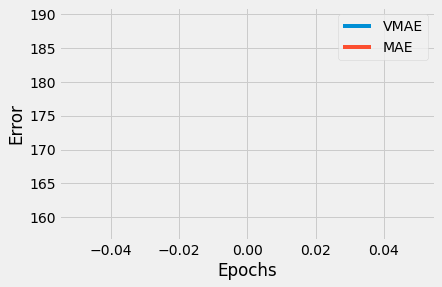

In [40]:
df = pd.DataFrame.from_records(result.history)
df['epoch'] = [i for i in range(df.shape[0])]

plt.plot(df['epoch'], df['val_mean_absolute_error'], label="VMAE")
plt.plot(df['epoch'], df['mean_absolute_error'], label="MAE")
# plt.xticks(df['epoch'])
plt.ylabel("Error")
plt.xlabel("Epochs")
plt.legend()
plt.show()

In [41]:
result.model.save('keras_model.h5')

In [48]:
A = result.model.predict(X_test)

In [53]:
len(A)

14823

# Tune

In [55]:
params = {
    'batch_size': [32],
    'epochs': [1]
}

grid = GridSearchCV(model,
                    params,
                    cv=2,
                    n_jobs=-1,
                    verbose=1)

grid_result = grid.fit(X_train, y_train)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:   21.4s finished


1853/1853 [==============================] - 10s 5ms/step - loss: 231087.7188 - mean_absolute_error: 196.0807


In [56]:
print(f"Best: {grid_result.best_score_} using {grid_result.best_params_}")
print(f"Mean test score: {grid_result.cv_results_['mean_test_score']}")

Best: -52775.326171875 using {'batch_size': 32, 'epochs': 1}
Mean test score: [-52775.32617188]


In [62]:
ins_array = ['Apartment', 'Entire home/apt', 3, 1.0, 'Real Bed',
          'strict', True, 'NYC', 1,
          1, 0, 40.696524, -73.991617,
          2, 1.0, 1.0]

In [63]:
array = [['Apartment'], ['Entire home/apt'], [3], [1.0], ['Real Bed'],
         ['strict'], [True], ['NYC'], [1],
         [1], [0], [40.696524], [-73.991617],
         [2], [1.0], [1.0]]

In [64]:
print(len(array))
array

16


[['Apartment'],
 ['Entire home/apt'],
 [3],
 [1.0],
 ['Real Bed'],
 ['strict'],
 [True],
 ['NYC'],
 [1],
 [1],
 [0],
 [40.696524],
 [-73.991617],
 [2],
 [1.0],
 [1.0]]

In [65]:
print(len(X.columns))
X.columns

16


Index(['property_type', 'room_type', 'accommodates', 'bathrooms', 'bed_type',
       'cancellation_policy', 'cleaning_fee', 'city', 'host_has_profile_pic',
       'host_identity_verified', 'instant_bookable', 'latitude', 'longitude',
       'number_of_reviews', 'bedrooms', 'beds'],
      dtype='object')

In [66]:
array = pd.DataFrame(array)

In [67]:
array = array.T

In [68]:
array = pd.DataFrame(array, columns=X.columns)

In [69]:
array.loc[-1] = ins_array
array.index = array.index + 1
array = array.sort_index()
array = array.drop([1])

In [70]:
array

,property_type,room_type,accommodates,bathrooms,bed_type,cancellation_policy,cleaning_fee,city,host_has_profile_pic,host_identity_verified,instant_bookable,latitude,longitude,number_of_reviews,bedrooms,beds
0,Apartment,Entire home/apt,3.0,1.0,Real Bed,strict,1.0,NYC,1.0,1.0,0.0,40.696524,-73.991617,2.0,1.0,1.0


In [76]:
array_x = np.asarray(array)

In [80]:
array_x

array([['Apartment', 'Entire home/apt', 3.0, 1.0, 'Real Bed', 'strict',
        1.0, 'NYC', 1.0, 1.0, 0.0, 40.696524, -73.991617, 2.0, 1.0, 1.0]],
      dtype=object)

In [78]:
grid_result.predict(array_x)

ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).